# Star Wars — Descriptive Analysis (Notebook → Streamlit Friendly)

This notebook is structured for clean conversion to Streamlit later. It avoids `display()` and 
uses a portable `show()` helper that works in notebooks, plain `.py`, and Streamlit.

To convert later:
```bash
jupyter nbconvert --to script starwars_eda_notebook.ipynb
streamlit run starwars_eda_notebook.py
```


In [12]:
# --- Imports & portable show() helper ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

try:
    import streamlit as st
    def show(obj, caption=None):
        if caption:
            st.subheader(caption)
        try:
            import pandas as _pd
            if isinstance(obj, _pd.DataFrame) or isinstance(obj, _pd.Series):
                st.dataframe(obj if isinstance(obj, _pd.DataFrame) else obj.to_frame())
            else:
                st.write(obj)
        except Exception:
            st.write(obj)
except Exception:
    st = None
    def show(obj, caption=None):
        if caption:
            print(f"\n## {caption}")
        if hasattr(obj, 'to_string'):
            print(obj.to_string())
        else:
            print(obj)

plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['axes.grid'] = True


In [13]:
# --- Config & Load ---
CSV_PATH = "../data/starwars/starwars_mocloose_sales_202510061222.csv"  # <-- adjust if needed
assert os.path.exists(CSV_PATH), f"CSV not found at {CSV_PATH}. Adjust CSV_PATH and re-run."
df = pd.read_csv(CSV_PATH, low_memory=False)

# Parse likely datetimes (best-effort, safe)
for col in df.columns:
    if any(k in col.lower() for k in ["date", "time", "timestamp"]):
        try:
            df[col] = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)
        except Exception:
            pass

print(f"Rows: {df.shape[0]:,} • Cols: {df.shape[1]}")
show(df.head(), caption="Preview: first 5 rows")
show(df.dtypes.astype(str), caption="Dtypes")


Rows: 52,062 • Cols: 7

## Preview: first 5 rows
  figure  authenticity_n  selling_price  sales     condition character_type  year
0   2-1B               0           8.59    0.4  loose_figure          droid  2013
1   2-1B               0          10.58    0.4  loose_figure          droid  2013
2   2-1B               0           9.58    0.4  loose_figure          droid  2013
3   2-1B               0           9.58    0.4  loose_figure          droid  2013
4   2-1B               0          10.58    0.4  loose_figure          droid  2013

## Dtypes
figure             object
authenticity_n      int64
selling_price     float64
sales             float64
condition          object
character_type     object
year                int64


In [3]:
# --- Basic descriptive stats ---
desc_all = df.describe(include='all').T
show(desc_all, caption="Descriptive statistics (all)")

unique_summary = {
    'figure_unique': df['figure'].nunique() if 'figure' in df.columns else None,
    'condition_unique': df['condition'].nunique() if 'condition' in df.columns else None,
    'character_type_unique': df['character_type'].nunique() if 'character_type' in df.columns else None,
}
show(pd.Series(unique_summary), caption="Unique counts (key categoricals)")



## Descriptive statistics (all)
                  count unique           top   freq         mean          std     min      25%      50%      75%       max
figure            52062    122     Chewbacca    535          NaN          NaN     NaN      NaN      NaN      NaN       NaN
authenticity_n  52062.0    NaN           NaN    NaN     0.444681     0.496935     0.0      0.0      0.0      1.0       1.0
selling_price   52062.0    NaN           NaN    NaN   346.672869  1575.778828     0.0  51.0825  122.115  290.165  130095.0
sales           52062.0    NaN           NaN    NaN     6.923053     9.555758     0.1      1.9      3.7      8.0      82.8
condition         52062      2  loose_figure  29570          NaN          NaN     NaN      NaN      NaN      NaN       NaN
character_type    52062      7   alien/other  18099          NaN          NaN     NaN      NaN      NaN      NaN       NaN
year            52062.0    NaN           NaN    NaN  2019.215301     3.606965  2009.0   2016.0   2019.0   

In [15]:
# --- Filtering utilities (centralized) ---
def apply_filters(df,
                  year_min=None, year_max=None,
                  conditions=None,
                  char_types=None,
                  q_low=0.0, q_high=1.0):
    dff = df.copy()
    if 'year' in dff.columns and (year_min is not None and year_max is not None):
        dff = dff[(dff['year'] >= year_min) & (dff['year'] <= year_max)]
    if conditions:
        dff = dff[dff['condition'].isin(conditions)]
    if char_types:
        dff = dff[dff['character_type'].isin(char_types)]
    # Outlier trim on price
    if 'selling_price' in dff.columns and 0.0 <= q_low < q_high <= 1.0:
        lo, hi = dff['selling_price'].quantile([q_low, q_high])
        dff = dff[(dff['selling_price'] >= lo) & (dff['selling_price'] <= hi)]
    return dff

# Defaults you can tweak per run (easy to port to Streamlit widgets later)
YEAR_MIN = int(df['year'].min()) if 'year' in df.columns else None
YEAR_MAX = int(df['year'].max()) if 'year' in df.columns else None
CONDITIONS = sorted(df['condition'].unique()) if 'condition' in df.columns else []
CHAR_TYPES = sorted(df['character_type'].unique()) if 'character_type' in df.columns else []

# Example defaults for analysis
flt_year_min, flt_year_max = YEAR_MIN, YEAR_MAX
flt_conditions = []          # e.g., ["loose_figure"]
flt_char_types = []          # e.g., ["droid", "human"]
flt_q_low, flt_q_high = 0.01, 0.99   # trim extreme 1% tails

dfv = apply_filters(df, flt_year_min, flt_year_max, flt_conditions, flt_char_types, flt_q_low, flt_q_high)
print(f"Filtered rows: {len(dfv):,} / {len(df):,}")


Filtered rows: 51,028 / 52,062


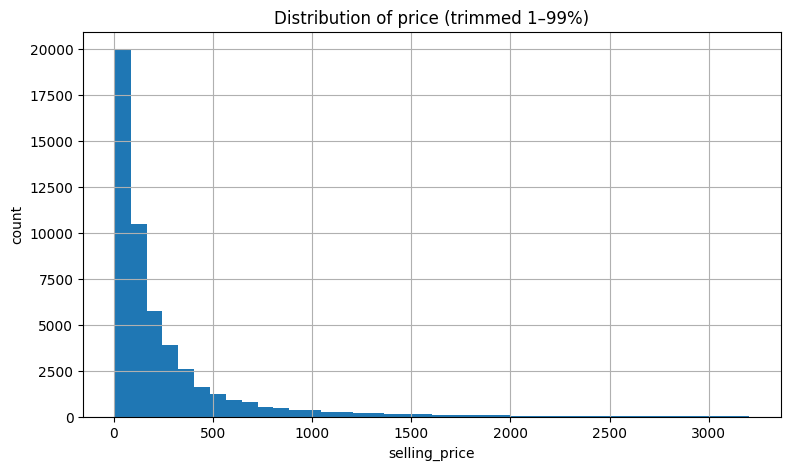

In [17]:
# --- Price distribution (with optional log scale) ---
USE_LOG = False  # set to True to use log1p(price)
price_col = 'selling_price'
plot_col = 'selling_price_log' if USE_LOG else price_col
if USE_LOG:
    dfv[plot_col] = np.log1p(dfv[price_col])

fig, ax = plt.subplots()
ax.hist(dfv[plot_col].dropna(), bins=40)
ax.set_title(f"Distribution of {'log1p(price)' if USE_LOG else 'price'} (trimmed {int(flt_q_low*100)}–{int(flt_q_high*100)}%)")
ax.set_xlabel(plot_col)
ax.set_ylabel('count')
if st: st.pyplot(fig)
else: plt.show()


/var/folders/xg/2vlsx6js7zl68g4305b178yw0000gn/T/ipykernel_52639/2142788152.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(groups, labels=order, showfliers=False)


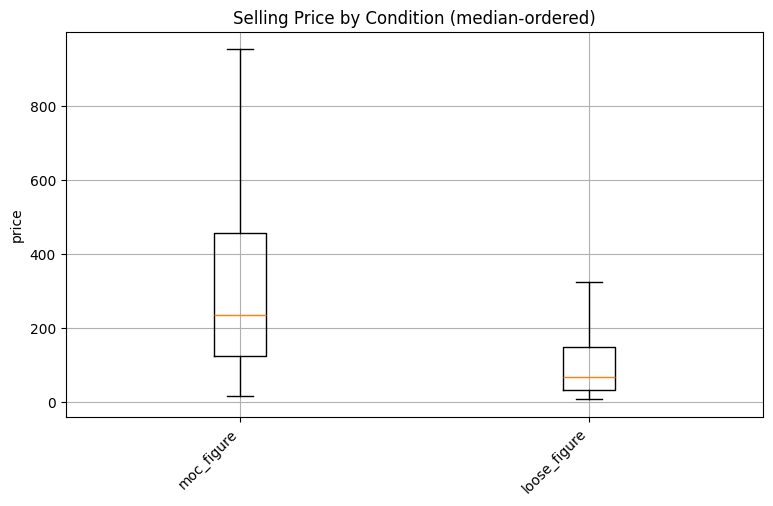

In [18]:
# --- Boxplot: price by condition (median-ordered) ---
if 'condition' in dfv.columns:
    order = dfv.groupby('condition')[price_col].median().sort_values(ascending=False).index.tolist()
    groups = [dfv.loc[dfv['condition']==c, price_col].dropna().values for c in order]
    fig, ax = plt.subplots()
    ax.boxplot(groups, labels=order, showfliers=False)
    ax.set_title('Selling Price by Condition (median-ordered)')
    ax.set_ylabel('price')
    plt.xticks(rotation=45, ha='right')
    if st: st.pyplot(fig)
    else: plt.show()
else:
    print("No 'condition' column found.")


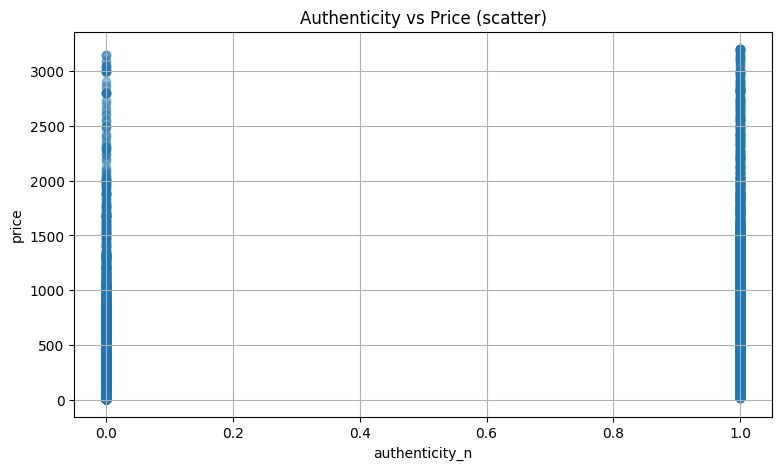

/var/folders/xg/2vlsx6js7zl68g4305b178yw0000gn/T/ipykernel_52639/1958176295.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = dfv.groupby(cuts)[price_col].mean()


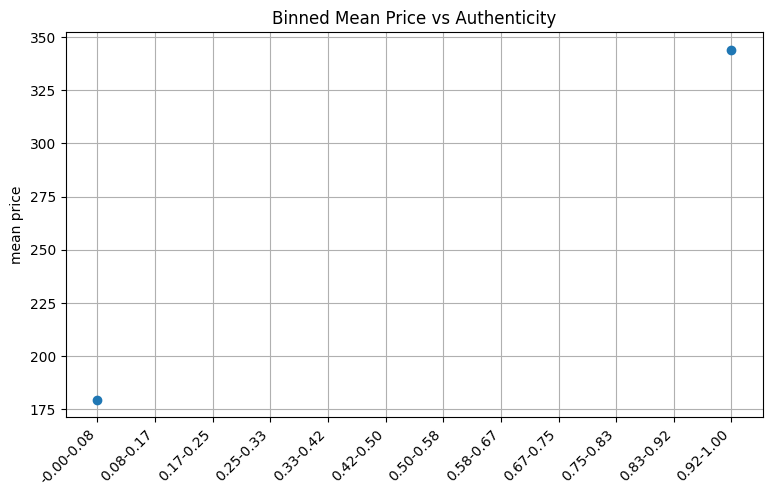

In [19]:
# --- Authenticity vs price: scatter + binned means ---
if 'authenticity_n' in dfv.columns:
    # scatter
    fig, ax = plt.subplots()
    ax.scatter(dfv['authenticity_n'], dfv[price_col], alpha=0.25)
    ax.set_title('Authenticity vs Price (scatter)')
    ax.set_xlabel('authenticity_n'); ax.set_ylabel('price')
    if st: st.pyplot(fig)
    else: plt.show()

    # binned means
    BINS = 12
    cuts = pd.cut(dfv['authenticity_n'], bins=BINS)
    binned = dfv.groupby(cuts)[price_col].mean()
    fig2, ax2 = plt.subplots()
    ax2.plot(range(len(binned)), binned.values, marker='o')
    ax2.set_xticks(range(len(binned)))
    ax2.set_xticklabels([f"{i.left:.2f}-{i.right:.2f}" for i in binned.index], rotation=45, ha='right')
    ax2.set_title('Binned Mean Price vs Authenticity')
    ax2.set_ylabel('mean price')
    if st: st.pyplot(fig2)
    else: plt.show()
else:
    print("No 'authenticity_n' column found.")


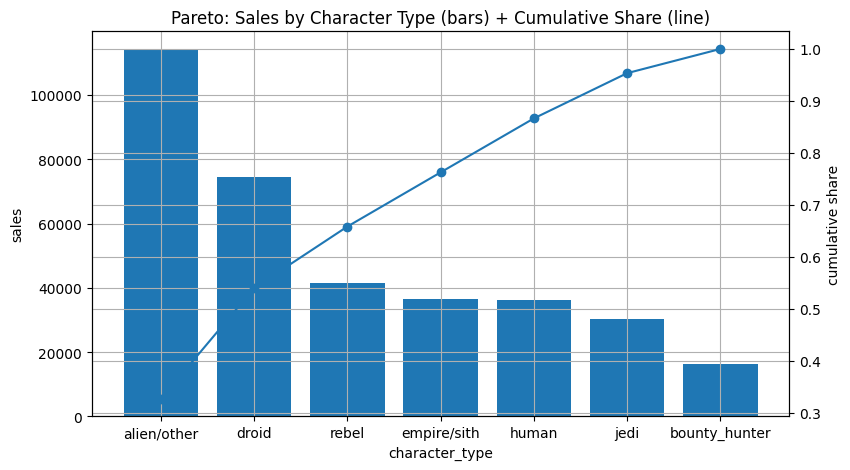

Top 7 categories account for 100.0% of total sales.


In [20]:
# --- Pareto: sales concentration by character_type ---
if 'character_type' in dfv.columns and 'sales' in dfv.columns:
    agg = dfv.groupby('character_type')['sales'].sum().sort_values(ascending=False)
    total = agg.sum() if agg.sum() != 0 else 1.0
    cum_share = (agg / total).cumsum()
    TOPN = min(15, len(agg))
    fig, ax = plt.subplots()
    ax.bar(agg.index[:TOPN], agg.values[:TOPN])
    ax2 = ax.twinx()
    ax2.plot(cum_share.index[:TOPN], cum_share.values[:TOPN], marker='o')
    ax.set_title('Pareto: Sales by Character Type (bars) + Cumulative Share (line)')
    ax.set_xlabel('character_type'); ax.set_ylabel('sales')
    ax2.set_ylabel('cumulative share')
    plt.xticks(rotation=45, ha='right')
    if st: st.pyplot(fig)
    else: plt.show()
    print(f"Top {TOPN} categories account for {cum_share.values[TOPN-1]*100:.1f}% of total sales.")
else:
    print("Need 'character_type' and 'sales' columns for Pareto.")


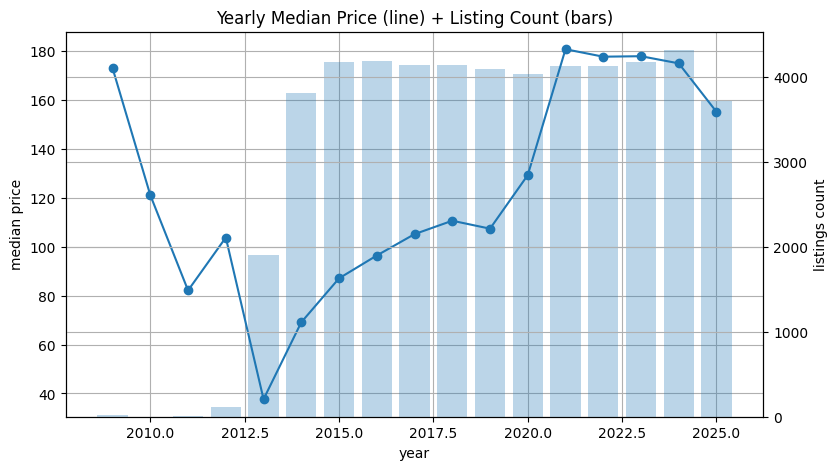

In [21]:
# --- Yearly trend: median price + listing volume ---
if 'year' in dfv.columns:
    dfv['year'] = pd.to_numeric(dfv['year'], errors='coerce')
    year_med = dfv.groupby('year')[price_col].median().dropna()
    year_cnt = dfv['year'].value_counts().sort_index()
    fig, ax = plt.subplots()
    ax.plot(year_med.index, year_med.values, marker='o')
    ax.set_title('Yearly Median Price (line) + Listing Count (bars)')
    ax.set_xlabel('year'); ax.set_ylabel('median price')
    ax2 = ax.twinx()
    ax2.bar(year_cnt.index, year_cnt.values, alpha=0.3)
    ax2.set_ylabel('listings count')
    if st: st.pyplot(fig)
    else: plt.show()
else:
    print("No 'year' column found.")


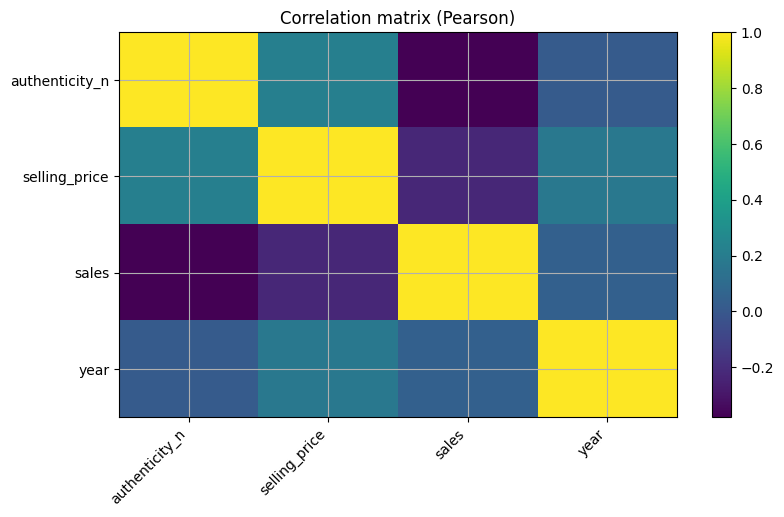

In [10]:
# --- Correlation heatmap (numeric only) ---
num_cols = [c for c in dfv.columns if pd.api.types.is_numeric_dtype(dfv[c])]
if len(num_cols) >= 2:
    corr = dfv[num_cols].corr(numeric_only=True)
    fig, ax = plt.subplots()
    im = ax.imshow(corr.values, aspect='auto')
    ax.set_xticks(range(len(corr.columns)))
    ax.set_xticklabels(corr.columns, rotation=45, ha='right')
    ax.set_yticks(range(len(corr.index)))
    ax.set_yticklabels(corr.index)
    ax.set_title('Correlation matrix (Pearson)')
    fig.colorbar(im)
    if st: st.pyplot(fig)
    else: plt.show()
else:
    print("Need at least two numeric columns for correlation.")


In [11]:
# --- Export filtered dataset (reproducible slice) ---
OUT_PATH = "../data/starwars/starwars_filtered.csv"
dfv.to_csv(OUT_PATH, index=False)
print(f"Saved filtered data to: {OUT_PATH}")


Saved filtered data to: ../data/starwars/starwars_filtered.csv
